In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

We imported necessary libraries like `seaborn`, `matplotlib`, `pandas`, and `numpy` for data manipulation, visualization, and modeling.

In [2]:
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


This dataset contains demographic and lifestyle information of individuals covered by health insurance. `age` represents the age of the primary beneficiary; `sex` indicates the gender of the insurance contractor; `bmi` refers to the body mass index (kg/m²); `children` shows the number of children or dependents covered by the insurance; `smoker` specifies whether the individual smokes; `region` indicates the residential area within the United States; and `charges` represent the individual medical costs billed by the health insurance.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

We verified if there are any missing values in the dataset to ensure data integrity.

In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


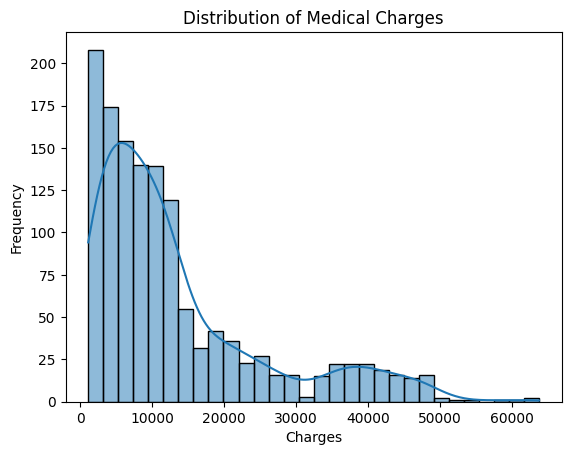

In [6]:
sns.histplot(df['charges'], bins=30, kde=True)
plt.title('Distribution of Medical Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

We visualized the distribution of medical charges to understand how costs are spread across the dataset.

In [7]:
print(df['region'].unique())
print(df['region'].value_counts())

['southwest' 'southeast' 'northwest' 'northeast']
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


We examined the distribution of geographic regions to see if the data is balanced across different areas.

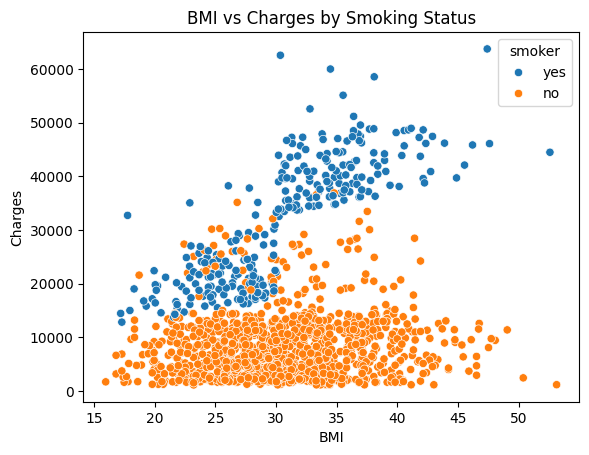

In [8]:
sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker')
plt.title('BMI vs Charges by Smoking Status')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()
# It seems that bmi does not effect charges but bmi * smoker has an effect on charges.

In [9]:
df_copy = df.copy()
df_copy = pd.get_dummies(df_copy, columns=['sex', 'smoker', 'region'], drop_first=True)
df_copy.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


We converted categorical variables into numerical format using one-hot encoding for model compatibility.

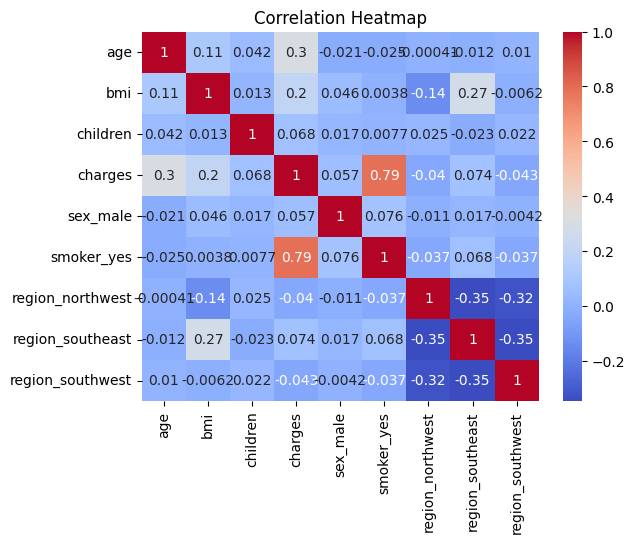

In [10]:
sns.heatmap(df_copy.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
# As i see person who is smoker has high correlation with charges. So we will analyze smoker and charges relationship.

We analyzed the correlation matrix to identify which features most strongly influence medical charges.

<Axes: xlabel='smoker_yes', ylabel='charges'>

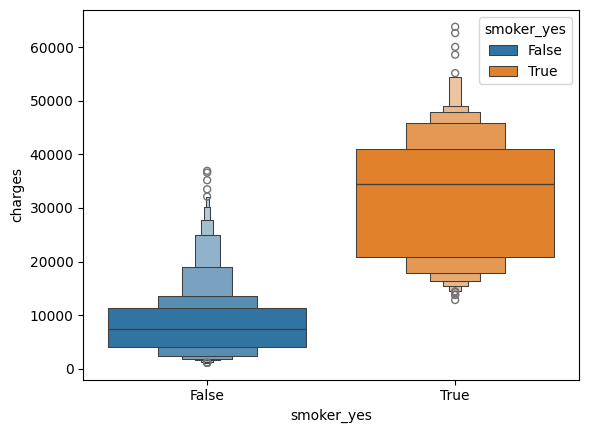

In [11]:
sns.boxenplot(x='smoker_yes', y='charges', data=df_copy, hue='smoker_yes')

We visualized how being a smoker impact medical charges using a boxenplot.

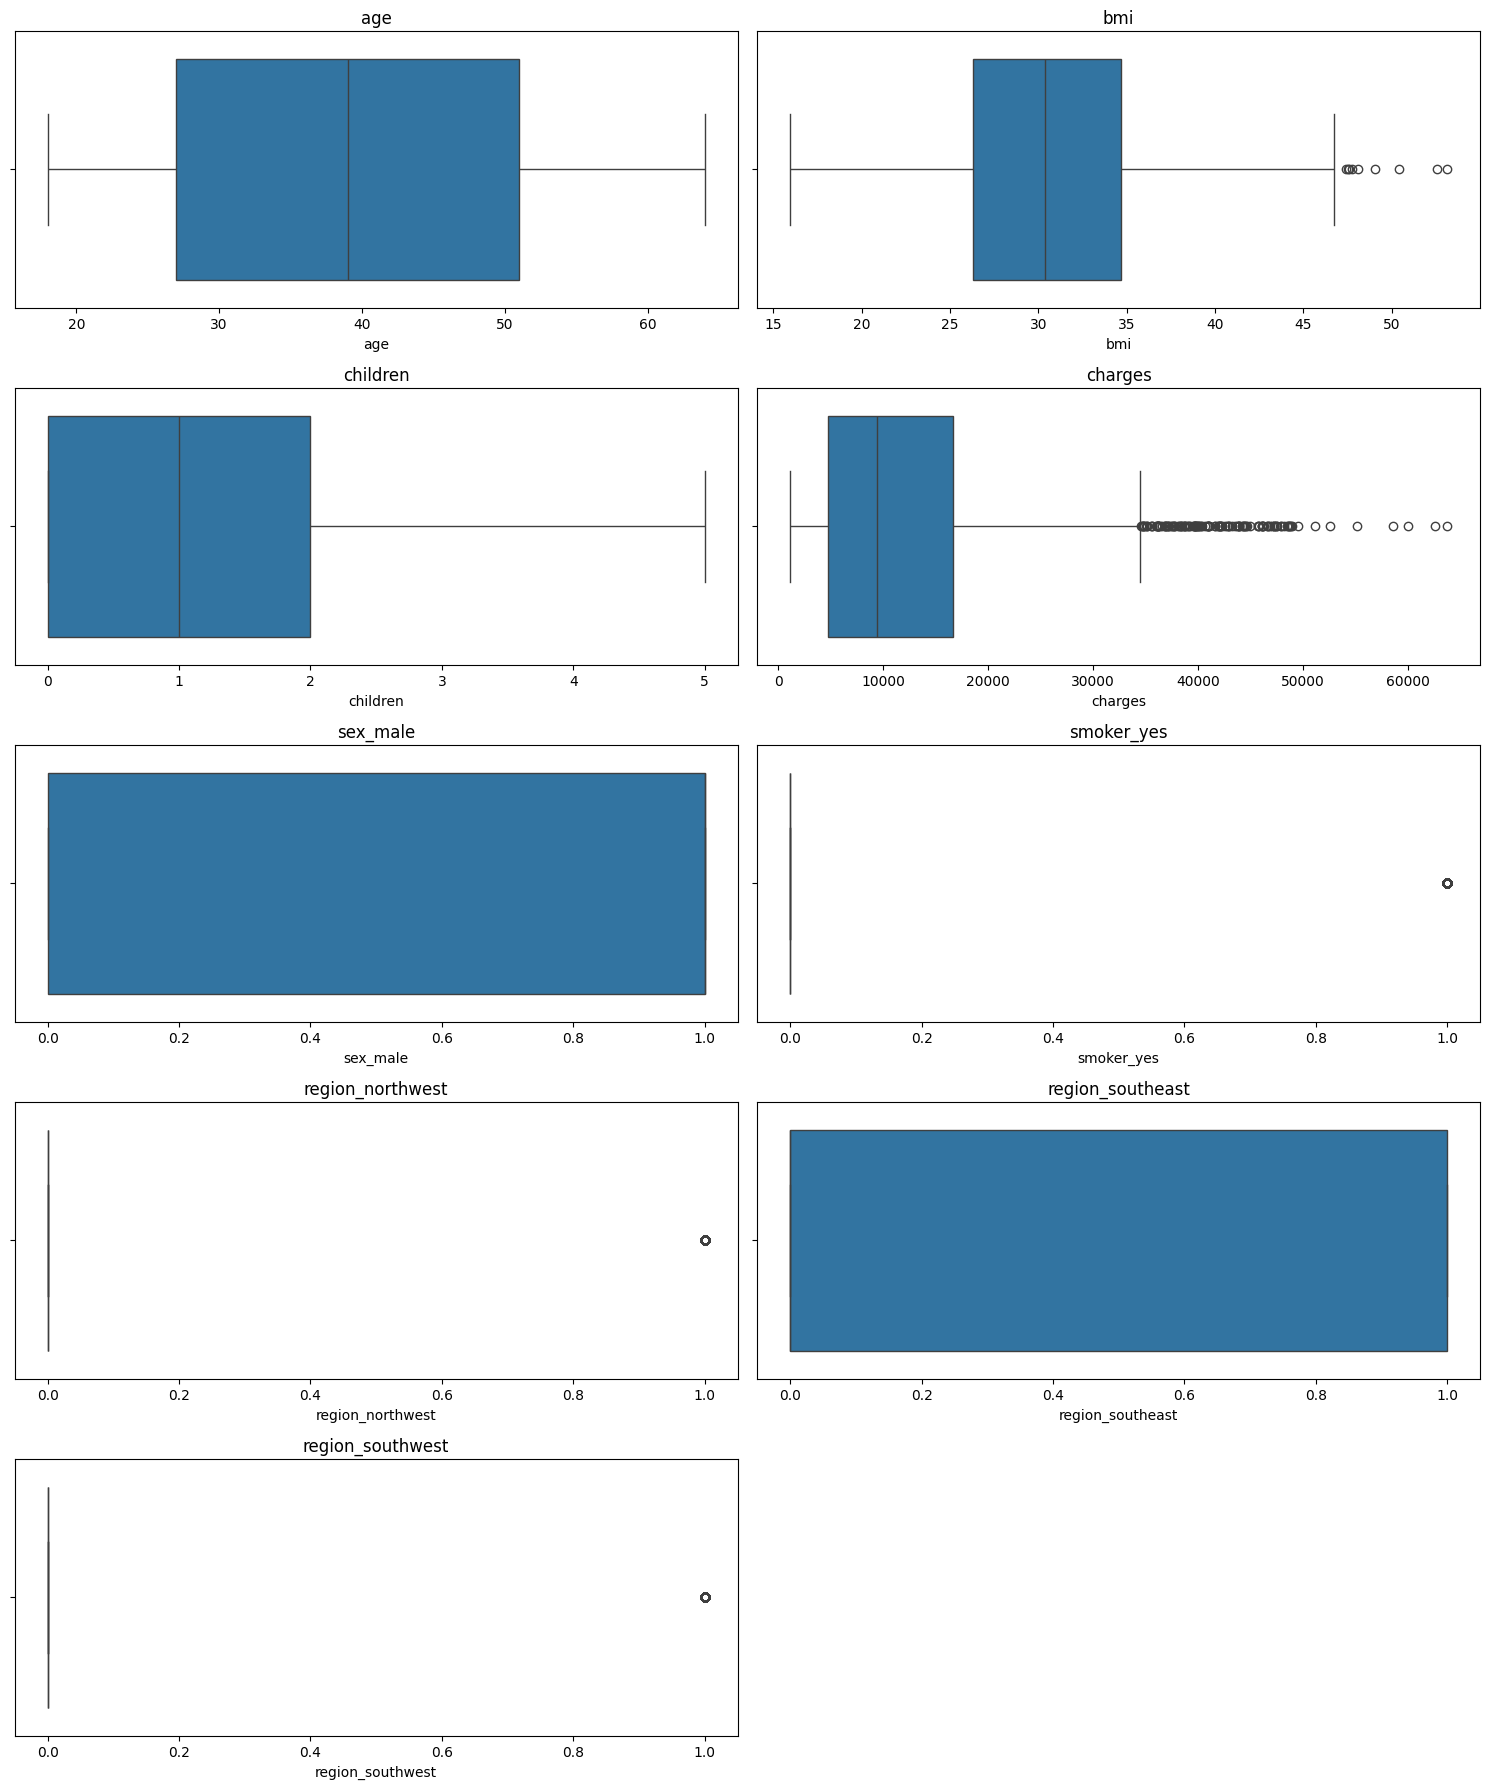

In [12]:
plt.figure(figsize=(15, len(df_copy.columns) * 2)) 
for i, col in enumerate(df_copy.columns, 1):
    plt.subplot(len(df_copy.columns) // 2 + 1, 2, i) 
    sns.boxplot(x=col, data=df_copy)
    plt.title(col)

plt.tight_layout()
plt.show()

We generated boxplots for all features to identify potential outliers and understand data spread.

In [13]:
#In bmi some outliers exist. We can handle them if necessary.
Q1 = df_copy['bmi'].quantile(0.25)
Q3 = df_copy['bmi'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
len(df_copy[(df_copy['bmi'] < lower_bound) | (df_copy['bmi'] > upper_bound)])
#so there is only 9 outliers in bmi column. We can remove them.
df_copy = df_copy[(df_copy['bmi'] >= lower_bound) & (df_copy['bmi'] <= upper_bound)]
df_copy.shape

(1329, 9)

We identified and removed outliers in the BMI column using the IQR method to improve model performance.

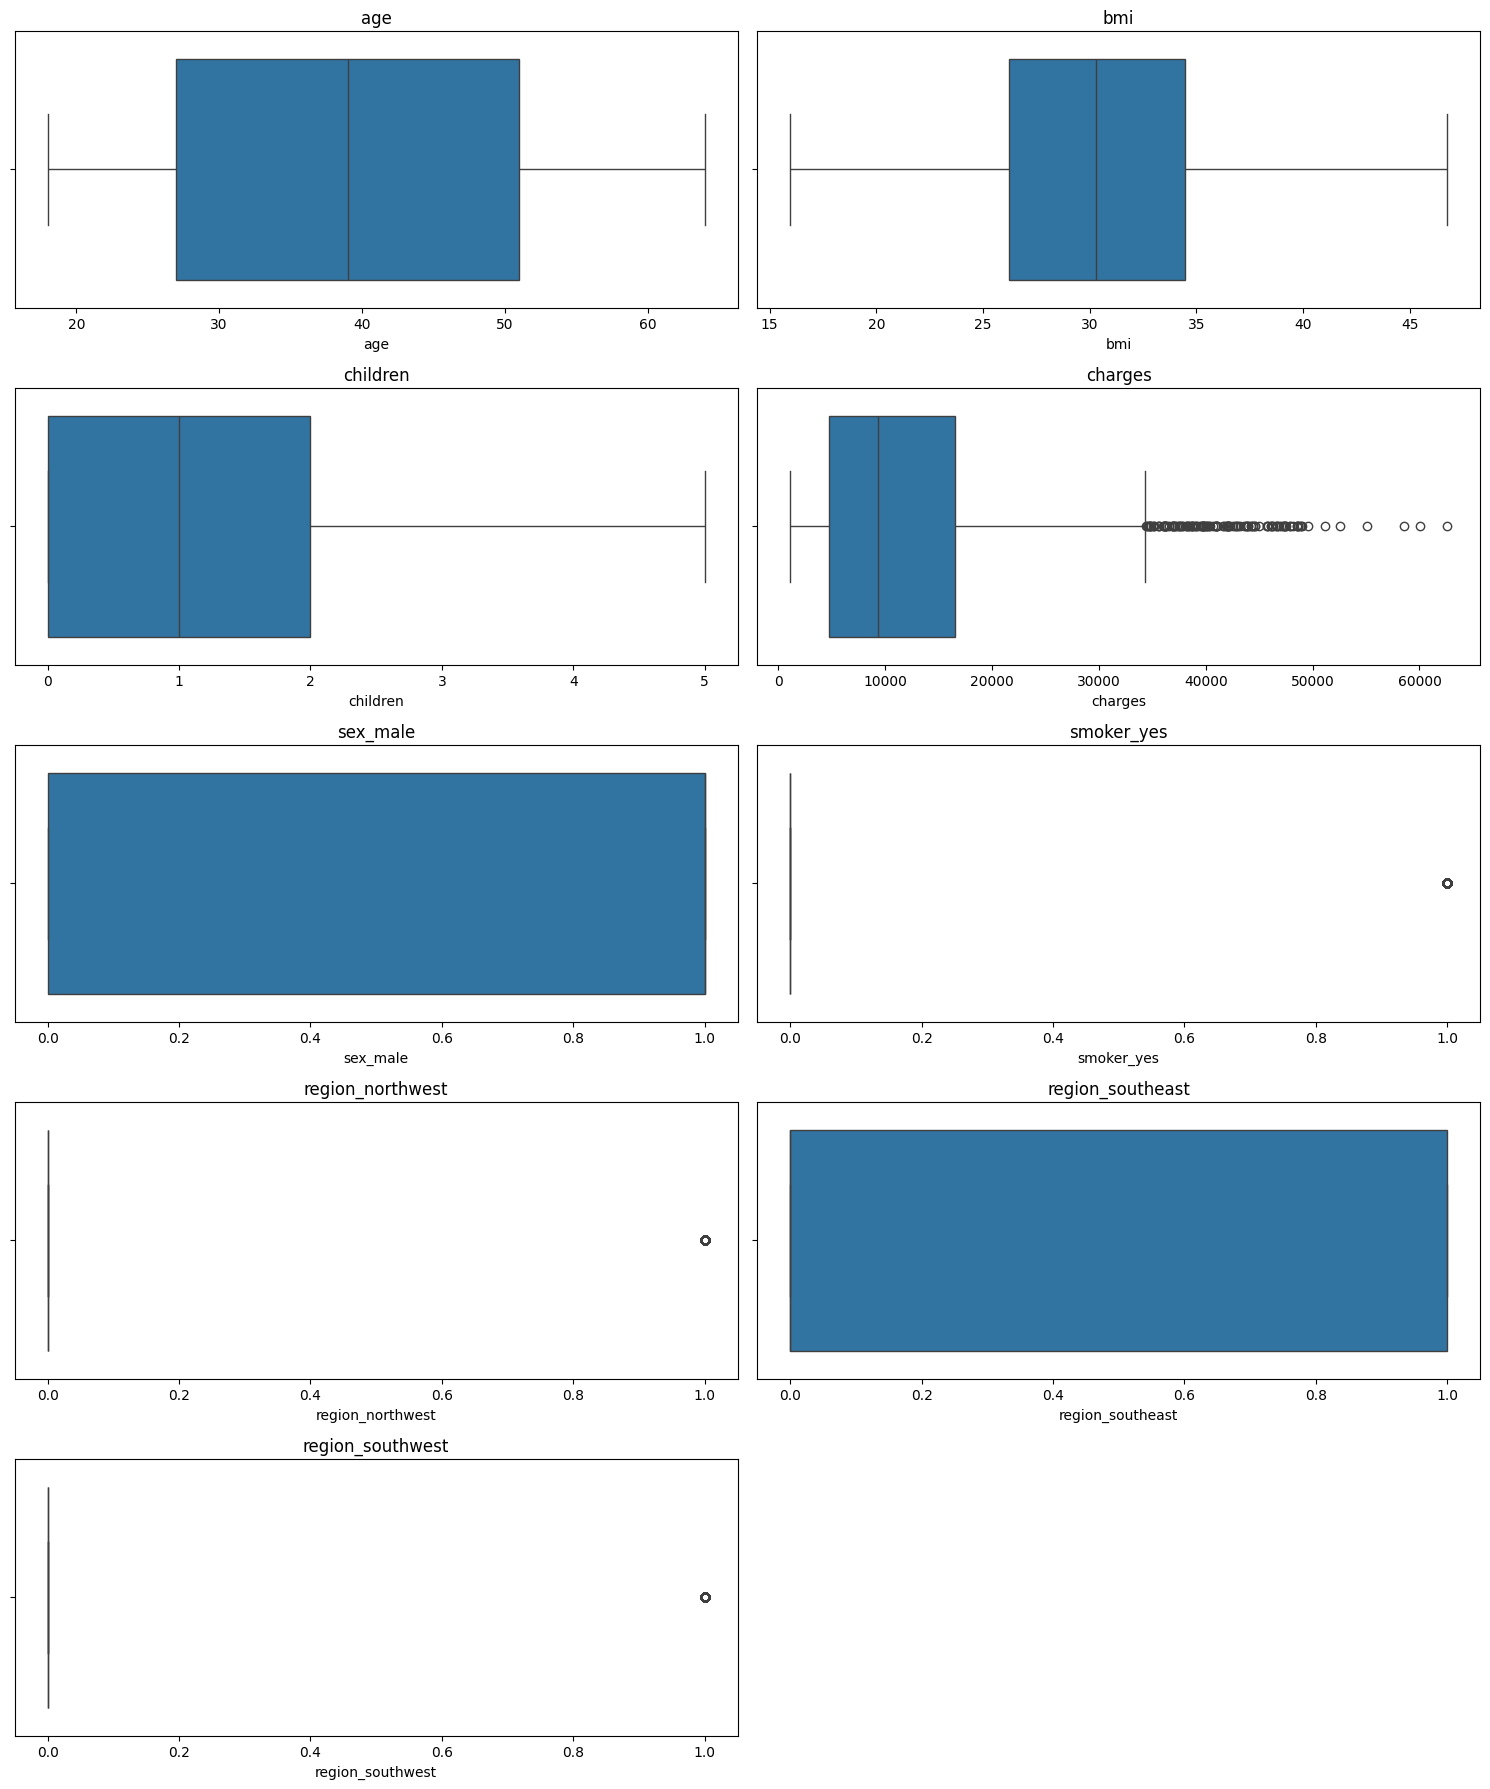

In [14]:
plt.figure(figsize=(15, len(df_copy.columns) * 2)) 
for i, col in enumerate(df_copy.columns, 1):
    plt.subplot(len(df_copy.columns) // 2 + 1, 2, i) 
    sns.boxplot(x=col, data=df_copy)
    plt.title(col)

plt.tight_layout()
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
X = df_copy.drop('charges', axis=1)
y = df_copy['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
#Now we can delete columns that is more correlated each other ,in our train and test data
#we do this to prevent multicollinearity
def correlation_for_dropping(data, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr # use these func when you want to drop highly correlated columns from your dataset to reduce multicollinearity and redundancy

We defined a function to identify highly correlated features, helping us reduce multicollinearity in the model.

In [17]:
print(correlation_for_dropping(X_train, 0.85)) # There's no highly correlated columns to drop


set()


We checked for highly correlated columns and found none exceeding our threshold.

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We standardized the feature scales to ensure that no single feature dominates the model due to its magnitude.

In [19]:
from sklearn.linear_model import  LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error # let's import our models

Linear Regression MAE: 3864.0201484438116
Linear Regression MSE: 30961925.235234555
Linear Regression R2: 0.7759274020112792
Adjusted R2: 0.770394745270817


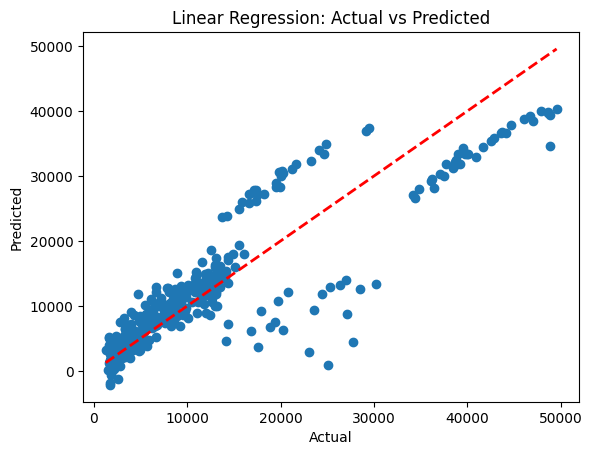

In [20]:
#with linear regression
linear = LinearRegression()
linear.fit(X_train_scaled, y_train)
y_pred = linear.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Linear Regression MAE: {mae}')
print(f'Linear Regression MSE: {mse}')
print(f'Linear Regression R2: {r2}')
adjusted_r2 = 1 - ( 1-r2 ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test_scaled.shape[1] - 1 )
print(f'Adjusted R2: {adjusted_r2}')
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()


We trained a Linear Regression model and evaluated it using MAE, MSE, and R2 scores.

In [21]:
importance = pd.DataFrame({'Feature': X.columns, 'Importance': linear.coef_})
importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
4,smoker_yes,9590.673941
0,age,3592.334328
1,bmi,2023.801613
2,children,595.992564
3,sex_male,-30.705075
5,region_northwest,-195.456478
7,region_southwest,-601.504164
6,region_southeast,-613.355402


We calculated and displayed the importance of each feature based on the model's coefficients.

RidgeCV Regression MAE: 3877.1126557714238
RidgeCV Regression MSE: 30987109.06891695
RidgeCV Regression R2: 0.7757451456755489
Adjusted R2: 0.7702079887786488


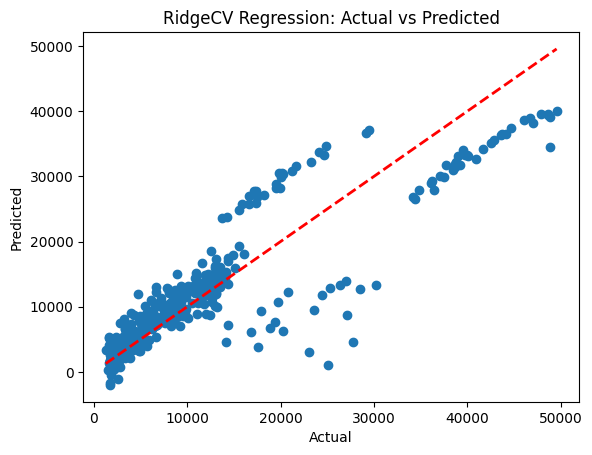

In [22]:
#Ridge with cross validation to find best alpha
from sklearn.linear_model import RidgeCV
ridgeCV = RidgeCV(cv=5)
ridgeCV.fit(X_train_scaled, y_train)
y_pred = ridgeCV.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RidgeCV Regression MAE: {mae}')
print(f'RidgeCV Regression MSE: {mse}')
print(f'RidgeCV Regression R2: {r2}')
adjusted_r2 = 1 - ( 1-r2 ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test_scaled.shape[1] - 1 )
print(f'Adjusted R2: {adjusted_r2}')
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('RidgeCV Regression: Actual vs Predicted')
plt.show()

We applied Ridge Regression with cross-validation to find the optimal regularization path and evaluate performance.

In [23]:
importance = pd.DataFrame({'Feature': X.columns, 'Importance': ridgeCV.coef_})
importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
4,smoker_yes,9492.261767
0,age,3557.373799
1,bmi,1999.316264
2,children,592.422842
3,sex_male,-22.950391
5,region_northwest,-184.736230
6,region_southeast,-585.946898
7,region_southwest,-586.185052


LassoCV Regression MAE: 3840.698078202319
LassoCV Regression MSE: 30845888.107317038
LassoCV Regression R2: 0.776767166997406
Adjusted R2: 0.7712552451948729


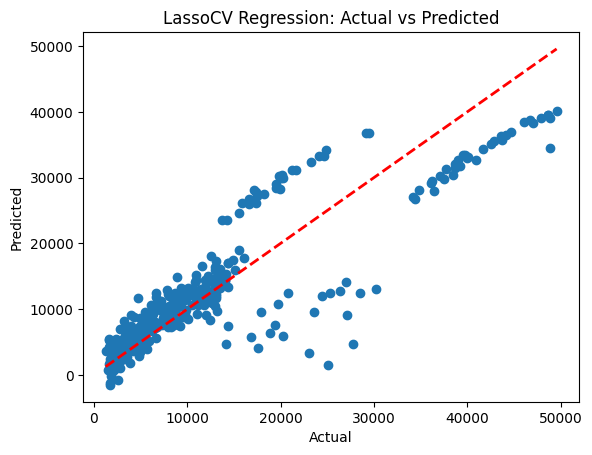

In [24]:
#Lasso with cross validation to find best alpha
from sklearn.linear_model import LassoCV
lassoCV = LassoCV(cv=5)
lassoCV.fit(X_train_scaled, y_train)
y_pred = lassoCV.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'LassoCV Regression MAE: {mae}')
print(f'LassoCV Regression MSE: {mse}')
print(f'LassoCV Regression R2: {r2}')
adjusted_r2 = 1 - ( 1-r2 ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test_scaled.shape[1] - 1 )
print(f'Adjusted R2: {adjusted_r2}')
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('LassoCV Regression: Actual vs Predicted')
plt.show()

In [25]:
importance = pd.DataFrame({'Feature': X.columns, 'Importance': lassoCV.coef_})
importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
4,smoker_yes,9491.844607
0,age,3523.558489
1,bmi,1891.143297
2,children,506.760618
3,sex_male,-0.000000
5,region_northwest,-0.000000
6,region_southeast,-333.484349
7,region_southwest,-351.561554


We trained a Lasso Regression model with cross-validation to identify relevant features through regularization.

In [26]:
#Model performances are very similar. but it's not enough to choose one of them.
#I'll try polynomial regression next.
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


We created polynomial features of degree 2 to capture non-linear relationships in the data.

In [27]:
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

We scaled the newly created polynomial features to ensure they are on the same range for modeling.

Polynomial Regression MAE: 2692.5106983051332
Polynomial Regression MSE: 19157727.689631
Polynomial Regression R2: 0.8613548162020955
Adjusted R2: 0.8396160243174067


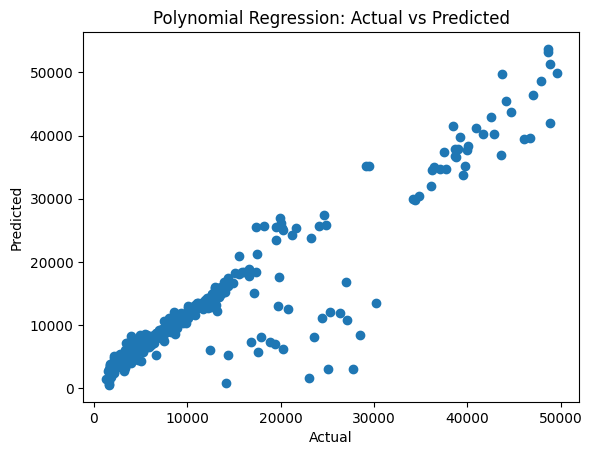

In [28]:
#with linear regression
linear = LinearRegression()
linear.fit(X_train_poly_scaled, y_train)
y_pred = linear.predict(X_test_poly_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Polynomial Regression MAE: {mae}')
print(f'Polynomial Regression MSE: {mse}')
print(f'Polynomial Regression R2: {r2}')
adjusted_r2 = 1 - ( 1-r2 ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test_poly_scaled.shape[1] - 1 )
print(f'Adjusted R2: {adjusted_r2}')
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Polynomial Regression: Actual vs Predicted')
plt.show()


We trained a Polynomial Regression model of degree 2 and evaluated its performance metrics.

Polynomial Regression MAE: 2768.6090841045493
Polynomial Regression MSE: 20638574.34940999
Polynomial Regression R2: 0.8506378741592928
Adjusted R2: 0.7030645162927258


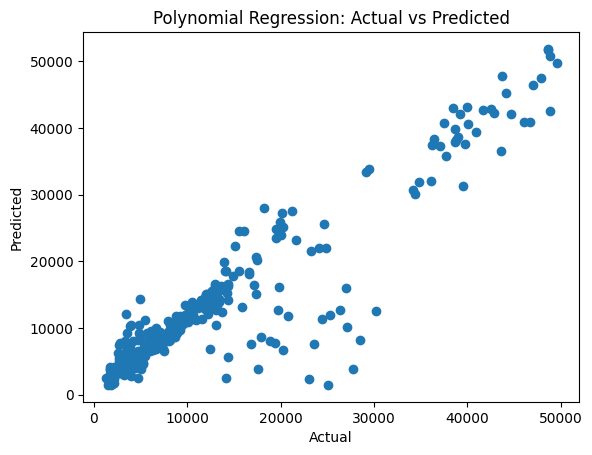

In [29]:
#with degree3
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)
linear = LinearRegression()
linear.fit(X_train_poly_scaled, y_train)
y_pred = linear.predict(X_test_poly_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Polynomial Regression MAE: {mae}')
print(f'Polynomial Regression MSE: {mse}')
print(f'Polynomial Regression R2: {r2}')
adjusted_r2 = 1 - ( 1-r2 ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test_poly_scaled.shape[1] - 1 )
print(f'Adjusted R2: {adjusted_r2}')
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Polynomial Regression: Actual vs Predicted')
plt.show()



We trained a Polynomial Regression model of degree 3 to check if higher-order interactions further improve the model.

Polynomial Lasso Regression MAE: 2662.867846210171
Polynomial Lasso Regression MSE: 19061105.254734457
Polynomial Lasso Regression R2: 0.8620540763368182
Adjusted R2: 0.8404249245429395


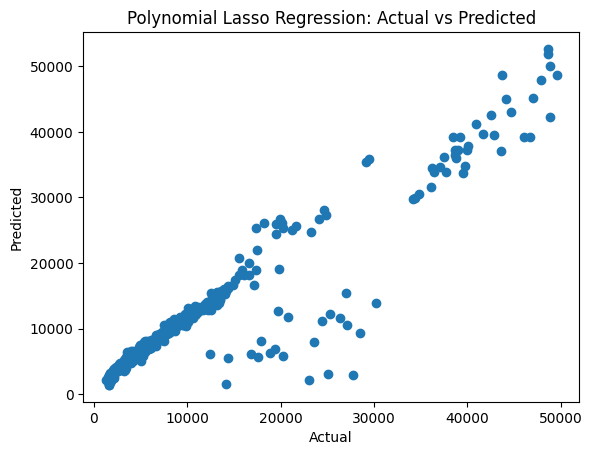

In [30]:
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)
lassoCV = LassoCV()
lassoCV.fit(X_train_poly_scaled, y_train)
y_pred = lassoCV.predict(X_test_poly_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Polynomial Lasso Regression MAE: {mae}')
print(f'Polynomial Lasso Regression MSE: {mse}')
print(f'Polynomial Lasso Regression R2: {r2}')
adjusted_r2 = 1 - ( 1-r2 ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test_poly_scaled.shape[1] - 1 )
print(f'Adjusted R2: {adjusted_r2}')
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Polynomial Lasso Regression: Actual vs Predicted')
plt.show()



In [32]:
importance = pd.DataFrame({'Feature': poly.get_feature_names_out(input_features=X.columns), 'Importance': lassoCV.coef_})
importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
20,bmi smoker_yes,17528.593395
9,age^2,3415.800575
3,children,1063.927595
15,age region_southeast,541.497176
16,age region_southwest,412.842596
10,age bmi,272.637035
2,bmi,244.383641
33,sex_male region_southeast,202.657299
27,children region_northwest,138.527545
18,bmi children,111.159461


Our best result is Polynomial degree 2 and Lasso CV Regression, from upper table we can see importance of features